## Graph Convolutional Networks in PyTorch

> PyTorch implementation of Graph Convolutional Networks (GCNs) for semi-supervised classification.

<div align="center">
    <img style="border-radius: 0.3125em; box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);"
    height="100"
    src="https://github.com/ximingxing/Images/raw/master/dlic/gnn/GCN.png">
    <br>
    <div style="border-bottom: 1px solid #d9d9d9;display:inline-block;color: #999;padding: 2px;
    font-style: oblique; font-family: 'Times New Roman'">
    Figure: Thomas Kipf, Graph Convolutional Networks (2016)</div>
</div>

**GCN的基本思想**: 把一个节点在图中的高纬度邻接信息降维到一个低维的向量表示.

**GCN的优点**: 可以捕捉`graph`的全局信息，从而很好地表示`node`的特征.

**GCN的缺点**: `Transductive learning`的方式, 需要把所有节点都参与训练才能得到`node embedding`, 无法快速得到新`node`的`embedding`.

**References:**
- Semi-Supervised Classification with Graph Convolutional Networks
- Paper: https://arxiv.org/abs/1609.02907
- Code: https://github.com/tkipf/pygcn

### Import Packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt

print('pytorch version:',torch.__version__,
      '\nnumpy version:' ,np.__version__,
      '\nmatplotlib version:' ,matplotlib.__version__)

# (可选) 适配项目路径
import sys
sys.path.insert(0, "/root/workshop/Deep-Learning-in-Action")

%matplotlib inline

pytorch version: 1.5.0 
numpy version: 1.18.2


### Define the GCN layer

In [3]:
class GraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim, use_bias=True):
        """图卷积：L*X*\theta

        Args:
        ----------
            input_dim: int
                节点输入特征的维度
            output_dim: int
                输出特征维度
            use_bias : bool, optional
                是否使用偏置
        """
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))
        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(output_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.use_bias:
            init.zeros_(self.bias)

    def forward(self, adjacency, input_feature):
        """邻接矩阵是稀疏矩阵, 因此在计算时使用稀疏矩阵乘法
    
        Args: 
        -------
            adjacency: torch.sparse.FloatTensor
                邻接矩阵
            input_feature: torch.Tensor
                输入特征
        """
        support = torch.mm(input_feature, self.weight)
        output = torch.sparse.mm(adjacency, support)
        if self.use_bias:
            output += self.bias
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
            + str(self.input_dim) + ' -> ' \
            + str(self.output_dim) + ')'
    

### Build GCN network model

In [4]:
class GCN(nn.Module):
    """
    定义一个包含两层GraphConvolution的模型
    """
    def __init__(self, input_dim=1433):
        super(GCN, self).__init__()
        self.gcn1 = GraphConvolution(input_dim, 16)
        self.gcn2 = GraphConvolution(16, 7)
    
    def forward(self, adjacency, feature):
        h = F.relu(self.gcn1(adjacency, feature))
        logits = self.gcn2(adjacency, h)
        return logits

### Defining hyperparameters

In [5]:
LEARNING_RATE = 0.1
WEIGHT_DACAY = 5e-4
EPOCHS = 40
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
from graph_neural_networks.GCN.cora import CoraData, tensor_from_numpy

# 加载数据，并转换为torch.Tensor
dataset = CoraData(data_root='./data/cora').data
node_feature = dataset.x / dataset.x.sum(1, keepdims=True)  # 归一化数据，使得每一行和为1
tensor_x = tensor_from_numpy(node_feature, DEVICE)
tensor_y = tensor_from_numpy(dataset.y, DEVICE)
tensor_train_mask = tensor_from_numpy(dataset.train_mask, DEVICE)
tensor_val_mask = tensor_from_numpy(dataset.val_mask, DEVICE)
tensor_test_mask = tensor_from_numpy(dataset.test_mask, DEVICE)
normalize_adjacency = CoraData.normalization(dataset.adjacency)   # 规范化邻接矩阵

num_nodes, input_dim = node_feature.shape
indices = torch.from_numpy(np.asarray([normalize_adjacency.row, 
                                       normalize_adjacency.col]).astype('int64')).long()
values = torch.from_numpy(normalize_adjacency.data.astype(np.float32))
tensor_adjacency = torch.sparse_coo_tensor(indices,values, size=(num_nodes, num_nodes)).to(DEVICE)
# tensor_adjacency = torch.sparse.FloatTensor(indices, values,
#                                             (num_nodes, num_nodes)).to(DEVICE)

Using Cached file: ./data/cora/processed_cora.pkl


### Init model, define optimizer and loss function

In [7]:
# 模型定义：Model, Loss, Optimizer
model = GCN(input_dim).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DACAY)

### Define training function

In [8]:
def train():
    loss_history = []
    val_acc_history = []
    model.train()
    train_y = tensor_y[tensor_train_mask]
    for epoch in range(EPOCHS):
        logits = model(tensor_adjacency, tensor_x)  # 前向传播
        train_mask_logits = logits[tensor_train_mask]   # 只选择训练节点进行监督
        loss = criterion(train_mask_logits, train_y)    # 计算损失值
        optimizer.zero_grad()
        loss.backward()     # 反向传播计算参数的梯度
        optimizer.step()    # 使用优化方法进行梯度更新
        train_acc, _, _ = test(tensor_train_mask)     # 计算当前模型训练集上的准确率
        val_acc, _, _ = test(tensor_val_mask)     # 计算当前模型在验证集上的准确率
        # 记录训练过程中损失值和准确率的变化，用于画图
        loss_history.append(loss.item())
        val_acc_history.append(val_acc.item())
        print("Epoch {:03d}: Loss {:.4f}, TrainAcc {:.4}, ValAcc {:.4f}".format(
            epoch, loss.item(), train_acc.item(), val_acc.item()))
    
    return loss_history, val_acc_history

def test(mask):
    model.eval()
    with torch.no_grad():
        logits = model(tensor_adjacency, tensor_x)
        test_mask_logits = logits[mask]
        predict_y = test_mask_logits.max(1)[1]
        accuarcy = torch.eq(predict_y, tensor_y[mask]).float().mean()
    return accuarcy, test_mask_logits.cpu().numpy(), tensor_y[mask].cpu().numpy()

### Visualize the training process

In [9]:
def plot_loss_with_acc(loss_history, val_acc_history):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(range(len(loss_history)), loss_history,
             c=np.array([255, 71, 90]) / 255.)
    plt.ylabel('Loss')
    
    ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
    ax2.plot(range(len(val_acc_history)), val_acc_history,
             c=np.array([79, 179, 255]) / 255.)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.ylabel('ValAcc')
    
    plt.xlabel('Epoch')
    plt.title('Training Loss & Validation Accuracy')
    plt.show()

### Training model

/pytorch/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Epoch 000: Loss 1.9476, TrainAcc 0.2, ValAcc 0.1920
Epoch 001: Loss 1.8788, TrainAcc 0.3214, ValAcc 0.1380
Epoch 002: Loss 1.7917, TrainAcc 0.6429, ValAcc 0.3880
Epoch 003: Loss 1.6742, TrainAcc 0.7714, ValAcc 0.5780
Epoch 004: Loss 1.5504, TrainAcc 0.85, ValAcc 0.6580
Epoch 005: Loss 1.4000, TrainAcc 0.9, ValAcc 0.6920
Epoch 006: Loss 1.2503, TrainAcc 0.9286, ValAcc 0.7360
Epoch 007: Loss 1.0976, TrainAcc 0.9286, ValAcc 0.7460
Epoch 008: Loss 0.9503, TrainAcc 0.9429, ValAcc 0.7540
Epoch 009: Loss 0.8169, TrainAcc 0.9429, ValAcc 0.7500
Epoch 010: Loss 0.6960, TrainAcc 0.9571, ValAcc 0.7400
Epoch 011: Loss 0.5970, TrainAcc 0.9714, ValAcc 0.7500
Epoch 012: Loss 0.5109, TrainAcc 0.9714, ValAcc 0.7680
Epoch 013: Loss 0.4417, TrainAcc 0.9786, ValAcc 0.7740
Epoch 014: Loss 0.3871, TrainAcc 0.9857, ValAcc 0.7720
Epoch 015: Loss 0.3423, TrainAcc 0.9857, ValAcc 0.7660
Epoch 016: Loss 0.3093, TrainAcc 0.9929, ValAcc 0.7720
Epoch 017: Loss 0.2830, TrainAcc 0.9929, ValAcc 0.7880
Epoch 018: Loss 0.

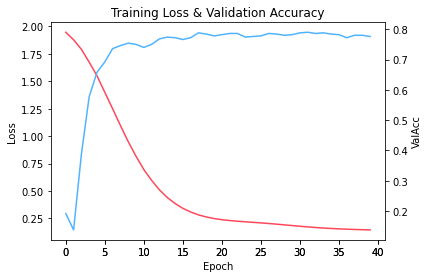

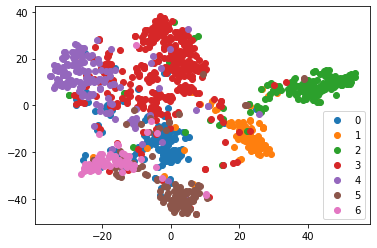

In [10]:
loss, val_acc = train()
test_acc, test_logits, test_label = test(tensor_test_mask)
print("Test accuarcy: ", test_acc.item())

plot_loss_with_acc(loss, val_acc)

# 绘制测试数据的TSNE降维图
from sklearn.manifold import TSNE
tsne = TSNE()
out = tsne.fit_transform(test_logits)
fig = plt.figure()
for i in range(7):
    indices = test_label == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))
plt.legend()